# Reinforcement Learning - Assignment

*Work in progress - please check back for updates.*

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
sns.set_style('ticks', {'axes.grid': True, 'grid.color': '.7', 'grid.linestyle': u'--'})
sns.set_palette('colorblind')
sns.set_context('talk')

## Part 1 - Improve Cart-Pole

If you've not already, complete through goal 2 of [Coding Challenge 1](../cc1/).
The first part of the assignment is to improve the policy for the agent that is
trying to keep the pole upright on the cart in the notebook
[16_reinforcement_learning.ipynb](https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb).
Read the notebook through `A simple hard-coded policy`, and then add your own
code (in your local Docker-powered environment) to try to do better.

As noted, the main problem with the simple approach is that it ends up moving
the cart too abruptly and losing stability. You can refer to the later sections
of the notebook for some hints on ways to improve with various techniques, but
your goal here is to write your own code leveraging knowledge from the various
resources you have available.

Please turn in an updated notebook with your strategy, as well as text in the
notebook describing it and its performance.

In [2]:
import gym
env = gym.make("CartPole-v0")
reward_history = []
  
for episode in range(10000):
  observation = env.reset()
  total_reward = 0
  for step in range(500):
    #env.render()
    if observation[2] < 0:
      action = 0
    else:
      action = 1
    observation, reward, done, info = env.step(action)
    total_reward += reward
    if done: break
  reward_history.append(total_reward)
env.close();

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


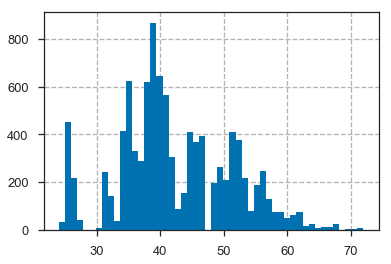

In [3]:
plt.hist(reward_history, bins=50);

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as distributions
import torch.optim
from collections import OrderedDict

class CartAgent():
  def __init__(self, env):
    self.env = env
    self.network = nn.Sequential(
      nn.Linear(self.env.observation_space.shape[0] + 1, 5),
      nn.Tanh(),
      nn.Linear(5, 1),
      nn.Sigmoid(),
    )
    for m in self.network.modules():
      if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)
        nn.init.constant_(m.bias, 0)
    self.best_reward = 0
    self.best_weights = self.network.state_dict()
    
  def shift_weights(self, std):
    normal = distributions.Normal(0, std)
    self.network.load_state_dict(OrderedDict([(op_name, tensor+normal.sample(tensor.shape)) for 
                                              op_name, tensor in self.best_weights.items()]))
    
  def begin_episode(self):
    self.time_step = 0
    return self.env.reset()
    
  def evaluate_action(self, observation):
    self.time_step += 1
    observation = torch.tensor(np.hstack((observation, [self.time_step])), dtype=torch.float32)
    return round(self.network(observation).item())

  def evaluate_final_reward(self, reward, verbose=False):
    if reward > self.best_reward:
      if verbose: print(reward)
      self.best_reward = reward
      self.best_weights = self.network.state_dict()
    #self.env.close()

In [3]:
agent = CartAgent(gym.make('CartPole-v0'))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
agent.env = gym.make('CartPole-v0')
agent.env.seed(0)
for episode in range(10000):
  agent.shift_weights(.1)
  total_reward = 0
  for _ in range(5):
    observation = agent.begin_episode()
    for _ in range(500):
      #agent.env.render()
      observation, reward, done, info = agent.env.step(agent.evaluate_action(observation))
      total_reward += reward
      if done: break
  agent.evaluate_final_reward(total_reward)
  if episode % 500 == 0 and episode != 0: print(f'run: {episode} -- best reward: {agent.best_reward / 5}')
agent.env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
run: 500 -- best reward: 130.0
run: 1000 -- best reward: 130.0
run: 1500 -- best reward: 130.0
run: 2000 -- best reward: 130.0
run: 2500 -- best reward: 130.0
run: 3000 -- best reward: 130.0
run: 3500 -- best reward: 130.0
run: 4000 -- best reward: 130.0
run: 4500 -- best reward: 130.0
run: 5000 -- best reward: 130.0
run: 5500 -- best reward: 130.0
run: 6000 -- best reward: 130.0
run: 6500 -- best reward: 130.0
run: 7000 -- best reward: 130.0
run: 7500 -- best reward: 130.0
run: 8000 -- best reward: 130.0
run: 8500 -- best reward: 130.0
run: 9000 -- best reward: 130.0
run: 9500 -- best reward: 130.0


In [5]:
agent.env = gym.make('CartPole-v0')
for episode in range(100):
  agent.shift_weights(0.0)
  observation = agent.begin_episode()
  total_reward = 0
  for step in range(500):
    agent.env.render()
    observation, reward, done, info = agent.env.step(agent.evaluate_action(observation))
    total_reward += reward
    if done: break
  agent.evaluate_final_reward(total_reward, True)
  if episode % 100 == 0 and episode != 0: print(f'run: {episode} -- best reward: {agent.best_reward}')
agent.env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import random
import gym

class CartAgentDeepQ():
  def __init__(self, environment, gamma_discont=.9, max_steps=2500):
    self.network = self.spawn_network()
    self.max_steps=max_steps
    self.memory_capacity = 10000
    self.memory_position = 0
    self.memory_buffer = []
    
  def push_memory(self, memory):
    if len(self.memory_buffer) < self.memory_capacity:
      self.memory_buffer.append(None)
    self.memory_buffer[self.memory_position] = memory
    self.memory_position = (self.memory_position + 1) % self.memory_capacity
  
  def spawn_network(self, hidden_dim=6):
    return nn.Sequential(
      nn.Linear(4, hidden_dim),
      nn.ELU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ELU(),
      nn.Linear(hidden_dim, 2),
    )

  def get_action(self, observation, eps_threshold):
    if random.sample() > eps_threshold:
      return network(observation.unsqueeze(0)).max(1)[1].cpu()
    else:
      return round(random.sample())
      
  
  def spawn_env(self):
    return gym.make('CartPole-v0')
  
  def train_episodes(self, seed=None):
    env = spawn_env()
    train_episode
    
    
  def train_episode(self, env, seed=None, render=False):
    if seed is not None: env.seed(seed)
    obs = env.reset()
    for step in range(self.max_steps):
      
      obs, reward, done, _ = obs.step()
      if done: break   

In [16]:
agent = CartAgentDeepQ()